# Continuous Data Stream

# Import

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam, SGD
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

import numpy as np
import random
import math

import time

import altair as alt
alt.data_transformers.disable_max_rows()
import pandas as pd
GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

random.seed(666)

Using cpu


# MFAN Network

In [2]:
class MFAN(torch.nn.Module):
    def __init__(self,
                 x_in, x_lr,
                 y_in, y_lr, d_lr,
                 hid_dims,# 500, 300, 300
                 d_loss_func=torch.nn.CrossEntropyLoss(),
                 enc_ABC=[1,1,1]):
        super(MFAN, self).__init__()
        self.x_net = torch.nn.Sequential( torch.nn.Linear(x_in, hid_dims[0]) ).to(device) # 784_500
        self.y_net = torch.nn.Sequential( torch.nn.Linear(y_in, hid_dims[0]) ).to(device) # 784_500
        self.d_net = torch.nn.Sequential( torch.nn.Linear(hid_dims[0], y_in) ).to(device) # 500_10
        for i in range(len(hid_dims)-1):
            self.x_net.append( torch.nn.Linear( hid_dims[i], hid_dims[i+1]) ).to(device)
            self.y_net.append( torch.nn.Linear( hid_dims[i], hid_dims[i+1]) ).to(device)
            self.d_net.append( torch.nn.Linear( hid_dims[i+1], y_in) ).to(device)
        self.relu = torch.nn.ReLU()
        # optimizers, loss
        self.x_opt = Adam(self.x_net.parameters(), lr=x_lr)
        self.y_opt = Adam(self.y_net.parameters(), lr=y_lr)
        self.d_opt = Adam(self.d_net.parameters(), lr=d_lr)
        # manual optimization................................................
        self.d_loss_func = d_loss_func
        self.A, self.B, self.C = enc_ABC

    def forward(self, x, y_pos, y_neg, layer_ind):
        Zx = self.x_net[layer_ind]( x ) # [60000, 500]
        Zys = self.y_net[layer_ind]( torch.cat([y_neg, y_pos],0) ) # [120000, 500]
        Zy_neg, Zy_pos = Zys[:len(y_neg)], Zys[len(y_pos):] # [60000, 500], [60000, 500]
        pos_sim = F.cosine_similarity(Zx, Zy_pos, dim=1) * self.A
        neg_sim = F.cosine_similarity(Zx, Zy_neg, dim=1) * self.B
        y_neg_similarity = F.cosine_similarity(Zy_neg, Zy_pos, dim=1) * self.C
        loss = (- pos_sim + neg_sim - y_neg_similarity).mean()
        self.x_opt.zero_grad()
        self.y_opt.zero_grad()
        loss.backward()
        #...............get grads, then optimze, (adjust learning rate here, loss)
        self.x_opt.step()
        self.y_opt.step()
        return Zx, Zy_pos, Zy_neg, loss.item()

    def d_forward(self, Zx, true_y_pos, layer_ind):
        y_pred = self.d_net[layer_ind]( Zx )
        # loss = self.d_loss_func(y_pred, true_y_pos)
        loss = torch.sqrt(self.d_loss_func(y_pred, true_y_pos))
        self.d_opt.zero_grad()
        loss.backward()
        self.d_opt.step()
        return y_pred, loss.item()

# (Baseline) BP


In [3]:
class BPNet(torch.nn.Module):
    def __init__(self, dims, b=120, epoch=50, loss_func=F.cross_entropy, lr=1e-2):
        super(BPNet, self).__init__()
        self.model_linear = torch.nn.Sequential()
        for i in range(len(dims)-2): # dims len=5, range is 0-3
            self.model_linear.append(torch.nn.Linear(dims[i],dims[i+1]))
            self.model_linear.append(torch.nn.LayerNorm(dims[i+1]),)
            self.model_linear.append(torch.nn.ReLU())
        self.model_linear.append(torch.nn.Linear(dims[-2],dims[-1]))
        self.model_linear.append(torch.nn.LayerNorm(dims[-1]))

        self.opt = torch.optim.Adam(self.model_linear.parameters(), lr=lr)
        self.epochs = epoch
        self.loss_func = loss_func
        self.batch_size = b

    def do_train(self, x, y):
        batch_size = self.batch_size
        model_linear = self.model_linear
        loss_func = self.loss_func
        opt = self.opt
        for epoch in range(self.epochs):
            for i in (range((x.shape[0]-1)//batch_size + 1)):
                start_i = i * batch_size
                end_i = start_i + batch_size
                xb = x[start_i:end_i]
                yb = y[start_i:end_i]
                pred = model_linear(xb)
                loss = self.loss_func(pred, yb)
                loss.backward()
                opt.step() # Updating weights.
                opt.zero_grad()
    def do_eval(self, x_tr, y_tr, plot_i=0, do_plot=True):
        with torch.no_grad():
            plot_x_tr, plot_y_tr = x_tr.clone().cpu().numpy(), y_tr.clone().cpu().numpy()

            y_pred_tr = self.model_linear(x_tr).detach().cpu()

            y_range = y_tr.max() - y_tr.min()
            eval_mse_tr = np.sqrt((((y_pred_tr-y_tr)/y_range)**2).mean()).item() # error measure

            if do_plot:
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.set_title("BP Train Result")
                ax.plot(plot_x_tr[plot_i], plot_y_tr[plot_i], '.-', label='Train') # ax.plot(x_tr[0], y_tr_neg[0], 'x-', label='negative')
                ax.plot(plot_x_tr[plot_i], y_pred_tr[plot_i].detach().cpu().numpy(), '--', label='Train predicted')
                ax.legend()
            # print('eval_mse: tr=',eval_mse_tr)
            return y_pred_tr[plot_i].detach().cpu().numpy(), eval_mse_tr

# Train()

In [4]:
def do_train(model, x, y_pos, y_neg, true_y=[], enc_batch_size=50, dec_batch_size=50, e_num_epoch=200, d_num_epoch=200):
    model.train()
    loss_dict = {'encoder':[], 'e_losses':[], 'e_batch_loss': [], 'e_all_l': [], 'e_all_loss':[],
                'decoder':[], 'd_losses':[], 'd_batch_loss': [], 'd_all_l': [], 'd_all_loss':[]}
    Zx_layers_tr = [] # store for Decoder training
    # ----------------------- Encoder ---------------------------
    for li in range(len(model.x_net)):
        Zx_layer_data_tr = []
        loss_dict['e_batch_loss'], loss_dict['e_all_l'] = [], []
        # for _ni in tqdm(range(e_num_epoch),
        #                 desc='Encode '+str(li+1)+'/'+str(len(model.x_net))+' layer; num_iter_batch='+str(x.shape[0]//enc_batch_size)):
        for _ni in range(e_num_epoch):
            Zx, Zy_pos, Zy_neg = [], [], []
            loss_dict['e_losses'] = []
            for i in range(x.shape[0]//enc_batch_size):
                start_i = i * enc_batch_size
                end_i = start_i + enc_batch_size
                xb, y_posb, y_negb = x[start_i:end_i], y_pos[start_i:end_i], y_neg[start_i:end_i]
                Zxb, Zy_posb, Zy_negb, _loss = model.forward(xb, y_posb, y_negb, li)
                loss_dict['e_losses'].append(_loss)
                loss_dict['e_all_l'].append(_loss)
                if Zx == []:
                    Zx, Zy_pos, Zy_neg = Zxb, Zy_posb, Zy_negb
                else:
                    Zx, Zy_pos, Zy_neg = torch.cat((Zx,Zxb),0), torch.cat((Zy_pos,Zy_posb),0), torch.cat((Zy_neg,Zy_negb),0)
            #-----end batch for
            loss_dict['e_batch_loss'].append(np.mean(loss_dict['e_losses']))
            Zx_layer_data_tr = Zx.detach() # use only the last n_epoch's Zx to train decoder
        #-----end num_epoches for
        Zx_layers_tr.append(Zx_layer_data_tr)
        loss_dict['encoder'].append(loss_dict['e_batch_loss'])
        loss_dict['e_all_loss'].append(loss_dict['e_all_l'])

        x, y_pos, y_neg = model.relu(F.normalize(Zx)).detach(), model.relu(F.normalize(Zy_pos)).detach(), model.relu(F.normalize(Zy_neg)).detach() # norm/regularization ---> use other types of regularization
    #-----end layer for
    # ----------------------- Decoder ---------------------------
    for li in range(len(model.x_net)):
        loss_dict['d_batch_loss'], loss_dict['d_all_l'] = [], []
        # for _ni in tqdm(range(d_num_epoch),
        #                 desc='Decode '+str(li+1)+'/'+str(len(model.x_net))+' layer; num_iter_batch='+str(Zx_layers_tr[0].shape[0]//dec_batch_size)):
        for _ni in range(d_num_epoch):
            Zx_tr = Zx_layers_tr[li]
            y_pos = true_y.clone().to(device)
            loss_dict['d_losses'] = []
            for i in range(Zx_tr.shape[0]//dec_batch_size):
                start_i = i * dec_batch_size
                end_i = start_i + dec_batch_size
                Zx_trb, y_posb = Zx_tr[start_i:end_i], y_pos[start_i:end_i]
                y_predb, _loss = model.d_forward(Zx_trb, y_posb, li)
                loss_dict['d_losses'].append(_loss)
                loss_dict['d_all_l'].append(_loss)
            #-----end batch for
            loss_dict['d_batch_loss'].append(np.mean(loss_dict['d_losses']))
        #-----end num_epoches for
        loss_dict['decoder'].append(loss_dict['d_batch_loss'])
        loss_dict['d_all_loss'].append(loss_dict['d_all_l'])
    #-----end layer for
    return model, loss_dict

In [5]:
def plot_loss(model, loss_dict):
    # ---------------------- Loss Plot --------------------------
    n_col = len(model.x_net)
    fig, axes = plt.subplots(nrows=1, ncols=n_col, figsize=(10, 2))
    for i in range(n_col):
        axes[i].plot(loss_dict['encoder'][i])
        axes[i].set_title('Encoder Loss L'+str(i))

    fig, axes = plt.subplots(nrows=1, ncols=n_col, figsize=(10, 2))
    for i in range(n_col):
        axes[i].plot(loss_dict['decoder'][i])
        axes[i].set_title('Decoder Loss L'+str(i))
# plot_loss(model, loss_dict)

# Eval()

In [6]:
def do_eval(model, x_tr_eval, y_tr_eval, plot_i=0, do_plot=True):
    model.eval()
    plot_x_tr, plot_y_tr = x_tr_eval.clone().cpu().numpy(), y_tr_eval.clone().cpu().numpy()
    # range
    # ================================ EVAL ========================================
    y_pred_layers, y_pred_layers_te = [], []
    eval_mse, eval_mse_te = [], []
    for i in range(len(model.d_net)):
        with torch.no_grad():
            #------train eval
            Zx_tr_eval = model.x_net[i](x_tr_eval)
            y_pred_tr = model.d_net[i](Zx_tr_eval)
            y_pred_layers.append(y_pred_tr)

            y_range = y_tr_eval.max() - y_tr_eval.min()
            eval_mse.append(np.sqrt((((y_pred_tr-y_tr_eval)/y_range)**2).mean()).item()) # error measure
            x_tr_eval = model.relu(F.normalize(Zx_tr_eval)).detach()
    if do_plot:
        # ======= plot train eval
        n_layer = len(model.x_net)
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_title("MFAN Train Result")
        ax.plot(plot_x_tr[plot_i], plot_y_tr[plot_i], '.-', label='Train')
        for i in range(1,n_layer):
            ax.plot(plot_x_tr[plot_i], y_pred_layers[i][plot_i].detach().cpu().numpy(), '.-', label='pred_L'+str(i))
        ax.legend()
    # ======= print error eval
    # print('eval_mse: tr=',eval_mse)
    k = np.argmin(eval_mse)
    _Ls_y = []
    for i in range(len(model.x_net)):
        _Ls_y.append(y_pred_layers[i][plot_i].detach().cpu().numpy())
    lowest_err = eval_mse[k]
    # print('min_mse:',lowest_err,'L',k)
    return _Ls_y, y_pred_layers[k][plot_i].detach().cpu().numpy(), k, lowest_err, eval_mse

# Create_time_series_data()

show out_data_sizes: 2901 * 100 :[ tensor(0.3777, dtype=torch.float64) ... tensor(19.0762, dtype=torch.float64) ] used all data? tensor(True)


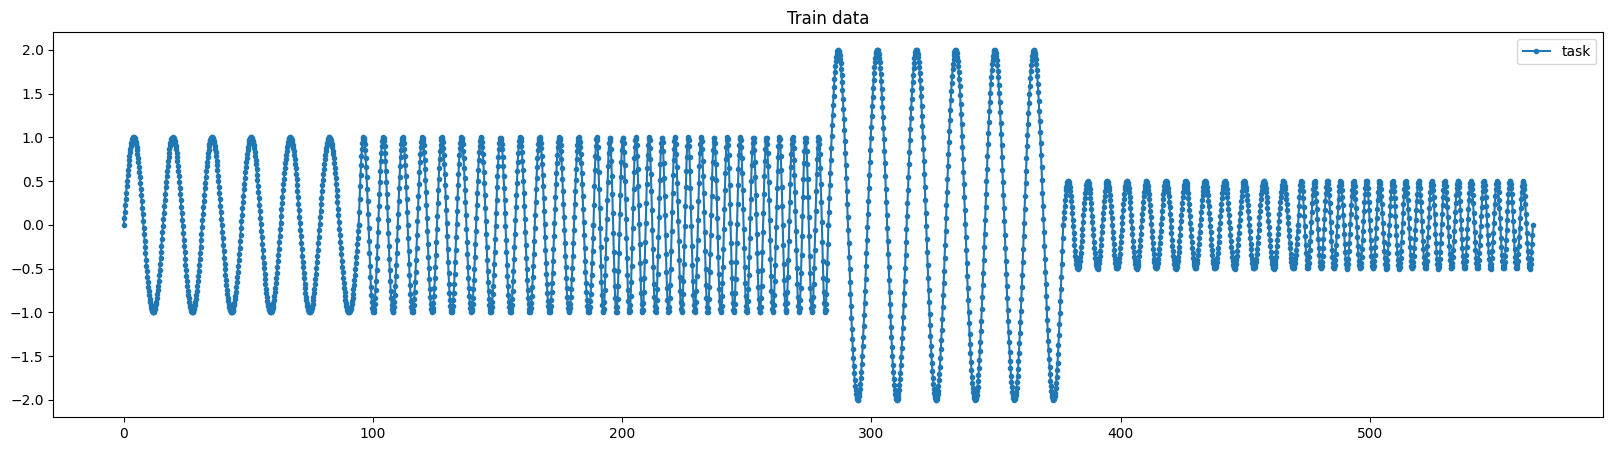

In [7]:
def get_y_time_series_neg(y, val_off=[0.05, 0.1]):
    y_neg = np.copy(y)
    r = np.random.rand(len(y_neg))
    rand_off = val_off[1]*(2*r -1)
    for i in range(len(rand_off)):
        if -val_off[0] < rand_off[i] <= 0:
            rand_off[i] = -val_off[0]
        elif 0 < rand_off[i] < val_off[0]:
            rand_off[i] = val_off[0]
    out = np.array(y_neg) + np.array(rand_off)
    return out
# c = 0
# f1 = lambda x: np.sin(0.4*x) + c
# f2 = lambda x: np.sin(0.8*x) + c
# f3 = lambda x: np.sin(1.2*x) + c
# f4 = lambda x: 2*np.sin(0.4*x) + c
# f5 = lambda x: 0.5*np.sin(0.8*x) + c
# f6 = lambda x: 0.5*np.sin(1.2*x) + c
def create_time_series_data(do_tasks=[lambda x: np.sin(0.4*x), lambda x: np.sin(0.8*x), lambda x: np.sin(1.2*x), lambda x: 2*np.sin(0.4*x), lambda x: 0.5*np.sin(0.8*x), lambda x: 0.5*np.sin(1.2*x)],
                            domain=30*np.pi, num_data=600, offset=[0.05, 0.1], do_plot=False, len_data=100, see_dp=True, see_tasks=True, see_neg=True):
    tasks_x = []
    tasks_y = []
    for i in range(len(do_tasks)):
        xi = np.linspace(i*domain, (i+1)*domain, 500)
        yi = do_tasks[i](xi)
        tasks_x = np.concatenate([tasks_x, xi], 0)
        tasks_y = np.concatenate([tasks_y, yi], 0)
    tasks_y_neg = get_y_time_series_neg(tasks_y, offset)

    if do_plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.set_title('Train data')
        d = 0
        ax.plot(tasks_x, tasks_y, '.-', label="task")
        if see_neg:
            ax.plot(tasks_x, tasks_y_neg, '.-', label="task (neg)")
        if see_tasks:
            for i in range(1,6):
                ind = len(tasks_x)/len(do_tasks)*i
                ax.axvline(x=tasks_x[int(ind)])
        ax.legend()
    # segment data streams:
    dom_data = domain/15
    num_data = len(tasks_x) - len_data+1 #2900
    out_x, out_y, out_y_neg = [], [], []
    for j in range(num_data):
        xj = torch.as_tensor(tasks_x[j:j+len_data])
        yj = torch.as_tensor(tasks_y[j:j+len_data])
        y_neg_j = torch.as_tensor(tasks_y_neg[j:j+len_data])
        out_x.append(xj)
        out_y.append(yj)
        out_y_neg.append(y_neg_j)
    print("show out_data_sizes:", len(out_x),'*',len(out_x[0]),':[',out_x[2][0],'...', out_x[2][-1],']', 'used all data?', out_x[-1][-1]==tasks_x[-1]) # 199, 100, 24.931276369169503
    if do_plot and see_dp:
        segs = [0, 45, 90, 180, 360, 720, 1440, 2000, 2500, 2900]
        for si in range(len(segs)):
            ax.hlines(y = si*0.1, xmin=out_x[segs[si]][0].item(), xmax=out_x[segs[si]][-1].item())
    return out_x, out_y, out_y_neg
x_data_tr, y_data_tr, y_data_tr_neg = create_time_series_data(do_plot=True, see_dp=False, see_neg=False, see_tasks=False)
x_stream, y_stream, y_stream_neg = torch.FloatTensor(np.array(x_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr_neg)).to(device)

#get_results()

In [9]:
def get_results(tr_period=15, eval_period=1, MFAN_lr=[1e-3, 1e-3, 1e-3], BP_lr=1e-4, MFAN_dim=[64,64,32,32,16,16], MFAN_enc_ABC=[0.6,0.4,0.4], BP_dim=[64,32,16]):
    x_stream, y_stream, y_stream_neg = torch.FloatTensor(np.array(x_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr_neg)).to(device)
    MFAN_start_time = time.time()
    # MFAN init>>>>>>>>>>>>>>>>>>>>>>>>>>
    x, y_pos, y_neg = x_stream.clone().to(device), y_stream.clone().to(device), y_stream_neg.clone().to(device)
    MFAN_lrx, MFAN_lry, MFAN_lrd = MFAN_lr
    MFAN_model = MFAN(x.shape[1], MFAN_lrx,
                    y_pos.shape[1], MFAN_lry, MFAN_lrd, MFAN_dim, enc_ABC=MFAN_enc_ABC,
                    d_loss_func=torch.nn.MSELoss())
    MFAN_eval_per_layer_err_collector = []
    for _ in range(len(MFAN_dim)):
        MFAN_eval_per_layer_err_collector.append([]) # tr & eval online per layer
    MFAN_eval_min_err_collector = [] # tr & eval online
    MFAN_use_L = []
    collect_x, collect_y_eval_pred= [], []
    for t in range(len(x)-tr_period):
        x_tr_t = x[t:t+tr_period]
        y_pos_tr_t = y_pos[t:t+tr_period]
        y_neg_tr_t = y_neg[t:t+tr_period]
        x_eval_t = x[t+tr_period:t+tr_period+eval_period]
        y_eval_t = y_pos[t+tr_period:t+tr_period+eval_period]


        MFAN_model, loss_dict = do_train(MFAN_model, x_tr_t, y_pos_tr_t, y_neg_tr_t, true_y=y_pos_tr_t, enc_batch_size=tr_period, dec_batch_size=tr_period, e_num_epoch=1, d_num_epoch=1)
        _MFAN_tr_Ls_pred, MFAN_tr_pred, L_use, lowest_err, all_err = do_eval(MFAN_model, x_eval_t, y_eval_t, plot_i=0, do_plot=False)

        # if t % 80 == 0:
        collect_x.append(np.array(np.squeeze(x_eval_t)))
        collect_y_eval_pred.append(MFAN_tr_pred)

        MFAN_eval_min_err_collector.append(lowest_err)
        for i in range(len(MFAN_eval_per_layer_err_collector)):
            MFAN_eval_per_layer_err_collector[i].append(all_err[i])
        MFAN_use_L.append(L_use)
    print('num_prints', len(x)-tr_period)
    print('MFAN took', time.time()-MFAN_start_time, 'seconds')

    BP_start_time = time.time()
    # BP init>>>>>>>>>>>>>>>>>>>>>>>>>>
    x, y = x_stream.clone().to(device), y_stream.clone().to(device) # IN data
    BP_lr=BP_lr
    BP_b=5
    BP_epoch=1
    IN_dim = [x.shape[1]]+ BP_dim + [y.shape[1]]
    BP_model = BPNet(IN_dim, b=BP_b, epoch=BP_epoch, loss_func=torch.nn.MSELoss(), lr=BP_lr)
    # tr & eval online
    BP_eval_err_collector = []
    collect_BP_x, BP_collect_y_eval_pred = [], []
    for t in range(len(x)-tr_period):
        x_tr_t = x[t:t+tr_period]
        y_tr_t = y[t:t+tr_period]

        x_eval_t = x[t+tr_period:t+tr_period+eval_period]
        y_eval_t = y_pos[t+tr_period:t+tr_period+eval_period]

        BP_model.train()
        BP_model.do_train(x_tr_t, y_tr_t)
        BP_model.eval()
        BP_tr_pred, err = BP_model.do_eval(x_eval_t, y_eval_t, plot_i=0, do_plot=False)

        if t % 80 == 0:
            collect_BP_x.append(np.array(np.squeeze(x_eval_t)))
            BP_collect_y_eval_pred.append(BP_tr_pred)

        BP_eval_err_collector.append(err)
    print('num_prints', len(x)-tr_period)
    print('BP took', time.time()-BP_start_time, 'seconds')
    return BP_eval_err_collector, MFAN_eval_min_err_collector, MFAN_eval_per_layer_err_collector, MFAN_use_L, collect_y_eval_pred, collect_x, BP_collect_y_eval_pred, collect_BP_x

# Error and prediction plot functions

In [10]:
def get_p(BP_eval_err_collector, MFAN_eval_err_collector, MFAN_use_L):# sins
    fig, ax = plt.subplots(figsize=(20, 5))
    MFAN_use_L_plot = 0.3*np.array(MFAN_use_L)
    ax.set_title("MFAN & BP RMSE_Err Compare")
    ax.plot(MFAN_eval_err_collector, label='MFAN', c='green', linewidth=5, alpha=0.9)
    ax.plot(MFAN_use_L_plot, 'x', c='lime', label='MFAN', alpha=0.9)
    for i in range(1,6):
        ax.axvline(x=(3000/6*i-100), linestyle='--')
        ax.axvline(x=(3000/6*i))

    ax.plot(BP_eval_err_collector, label='BP', c='orange', linewidth=5, alpha=0.6)
    ax.legend()
    plt.show()

def get_p_l(BP_eval_err_collector, MFAN_eval_per_layer_err_collector, MFAN_use_L):
    li = 0
    for collector in MFAN_eval_per_layer_err_collector:
        fig, ax = plt.subplots(figsize=(20, 5))
        MFAN_use_L_plot = 0.3*np.array(MFAN_use_L)
        title_li = "MFAN & BP RMSE_Err Compare: Layer " + str(li)
        ax.set_title(title_li)
        li += 1
        ax.plot(collector, label='MFAN', c='green', linewidth=3, alpha=0.9)
        # for i in range(1,6):
        #     ax.axvline(x=3000/6*i)
        ax.plot(BP_eval_err_collector, label='BP', c='orange', linewidth=3, alpha=0.6)
        ax.legend()
        plt.show()
    # fig, ax = plt.subplots(figsize=(20, 5))
    # MFAN_use_L_plot = 0.3*np.array(MFAN_use_L)
    # ax.set_title("MFAN & BP RMSE_Err Compare")
    # ax.plot(MFAN_eval_err_collector, label='MFAN', c='green', linewidth=5, alpha=0.9)
    # for i in range(1,6):
    #     ax.axvline(x=3000/6*i)

    # ax.plot(BP_eval_err_collector, label='BP', c='orange', linewidth=5, alpha=0.6)
    # ax.legend()

In [11]:
def do_task_xy(do_tasks, domain=30*np.pi):
    tasks_x = []
    tasks_y = []
    for i in range(len(do_tasks)):
        xi = np.linspace(i*domain, (i+1)*domain, 500)
        yi = do_tasks[i](xi)
        tasks_x = np.concatenate([tasks_x, xi], 0)
        tasks_y = np.concatenate([tasks_y, yi], 0)
    return tasks_x, tasks_y

def get_BP_p_lines(collect_BP_x, collect_y_eval_pred, do_tasks):
    fig, ax = plt.subplots(figsize=(20, 5))
    tasks_x, tasks_y = do_task_xy(do_tasks)
    ax.plot(tasks_x, tasks_y, label="task", c='blue', linewidth=7, alpha=0.3)
    j = 0
    for i in range(len(collect_BP_x)):
        ax.plot(collect_BP_x[i], collect_y_eval_pred[i], c='green', linewidth=2, alpha=0.9)
        if i != 0 and i % (len(collect_BP_x) // 6) == 0:
            if j < 5:
                j+=1
                ax.axvline(x=collect_BP_x[i-int(100/5//80)][0], linestyle='--')
                ax.axvline(x=collect_BP_x[i][-1])
    plt.show()

def get_p_lines(collect_x, collect_y_eval_pred, do_tasks):
    fig, ax = plt.subplots(figsize=(20, 5))
    tasks_x, tasks_y = do_task_xy(do_tasks)
    ax.plot(tasks_x, tasks_y, label="task", c='blue', linewidth=7, alpha=0.3)
    j = 0
    for i in range(len(collect_x)):
        ax.plot(collect_x[i], collect_y_eval_pred[i], c='green', linewidth=1, alpha=1)
        if i != 0 and i % (len(collect_x) // 6) == 0:
            if j < 5:
                j+=1
                ax.axvline(x=collect_x[i-100//5][0], linestyle='--')
                ax.axvline(x=collect_x[i][-1])
    plt.show()

# Test results

## Sin tasks

In [12]:
# DEFAULT tasks:
do_tasks=[lambda x: np.sin(0.4*x), lambda x: np.sin(0.8*x), lambda x: np.sin(1.2*x), lambda x: 2*np.sin(0.4*x), lambda x: 0.5*np.sin(0.8*x), lambda x: 0.5*np.sin(1.2*x)]

# Data and Plot
x_data_tr, y_data_tr, y_data_tr_neg = create_time_series_data(do_plot=False, see_dp=False, see_neg=False, see_tasks=False)
x_stream, y_stream, y_stream_neg = torch.FloatTensor(np.array(x_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr_neg)).to(device)

# Train Model
BP_eval_err_collector, MFAN_eval_err_collector, MFAN_eval_per_layer_err_collector, MFAN_use_L, collect_y_eval_pred, collect_x, BP_collect_y_eval_pred, collect_BP_x = get_results(
    tr_period=5,
    eval_period=1,
    MFAN_lr=[1e-5,1e-5,1e-4], BP_lr=1e-1,
    MFAN_dim=[64,32,16],
    BP_dim=[64,32,16])

show out_data_sizes: 2901 * 100 :[ tensor(0.3777, dtype=torch.float64) ... tensor(19.0762, dtype=torch.float64) ] used all data? tensor(True)


<ipython-input-6-62c2aa8404ca>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt((((y_pred_tr-y_tr_eval)/y_range)**2).mean()).item()) # error measure


num_prints 2896
MFAN took 35.45606803894043 seconds


<ipython-input-3-976d2c0a6bb3>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt((((y_pred_tr-y_tr)/y_range)**2).mean()).item() # error measure


num_prints 2896
BP took 8.59116005897522 seconds


MFAN


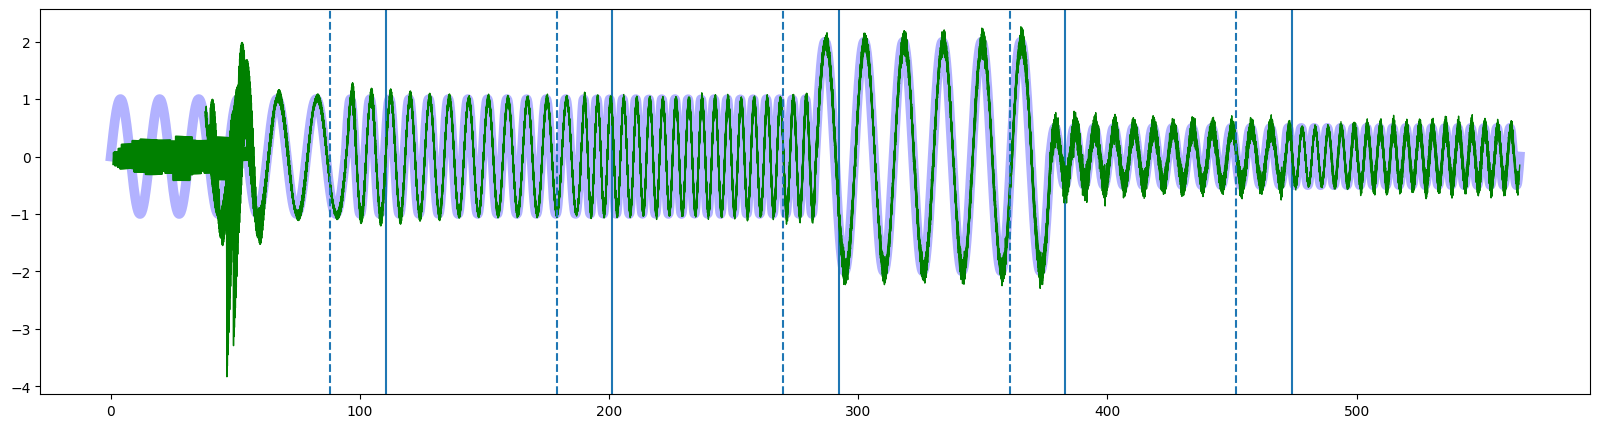

BP


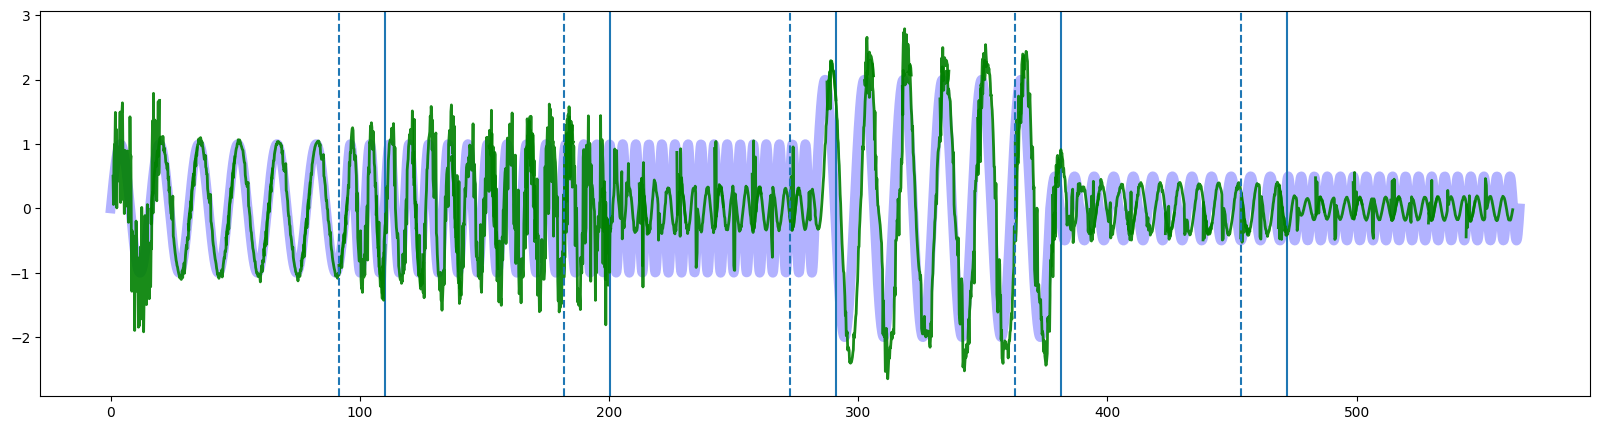

Lowest Error


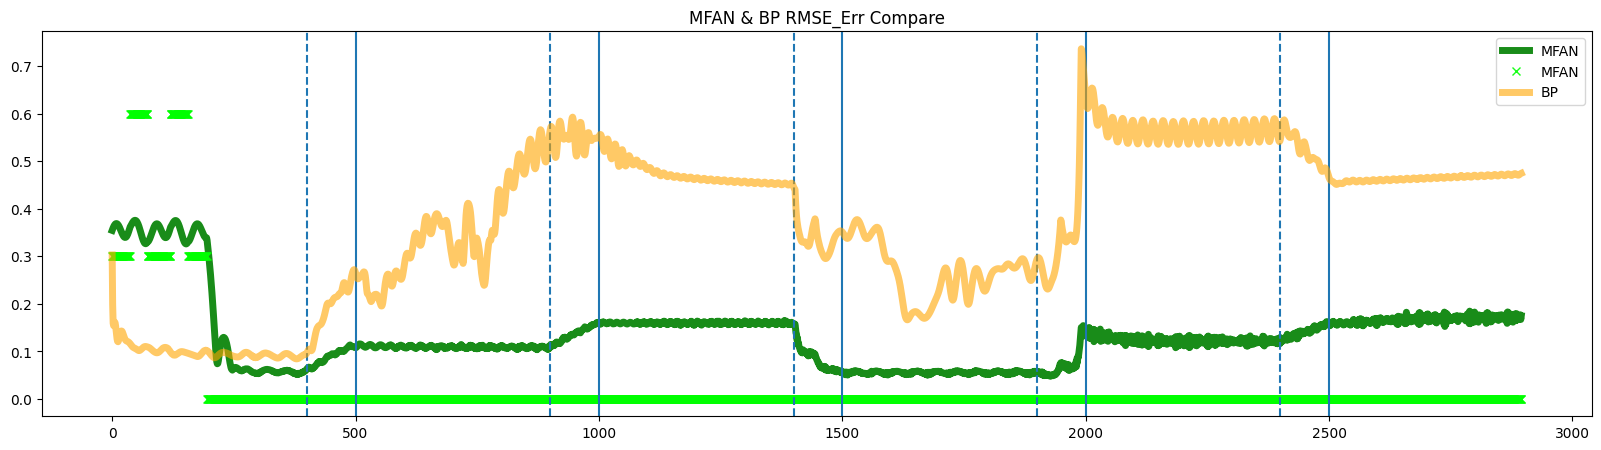

MFAN Layers Error


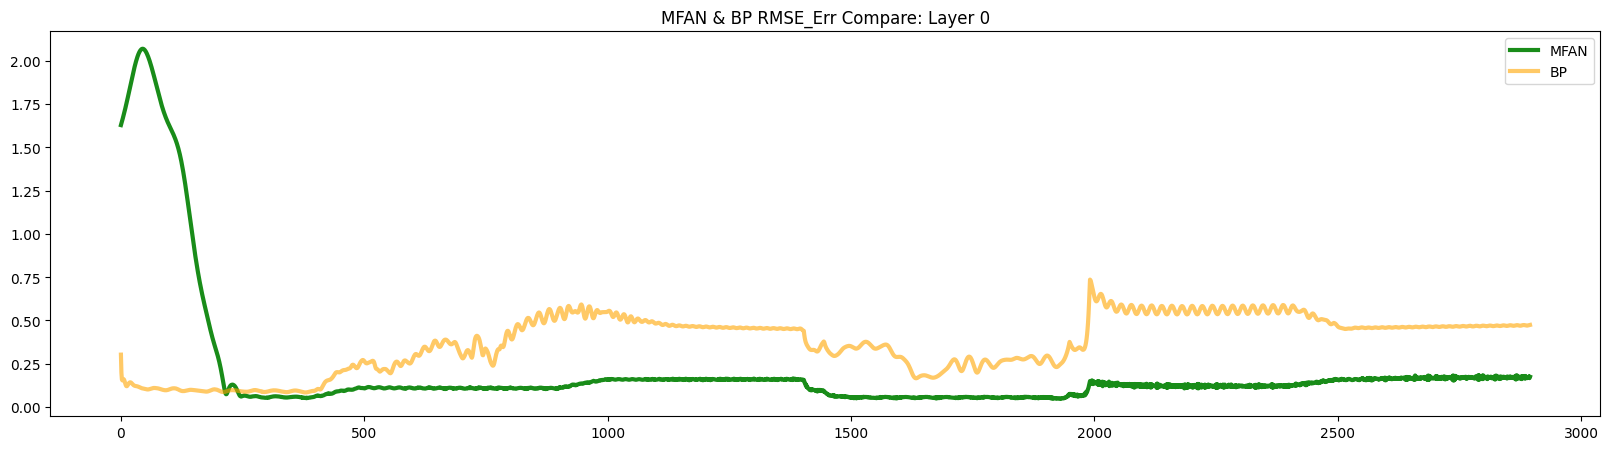

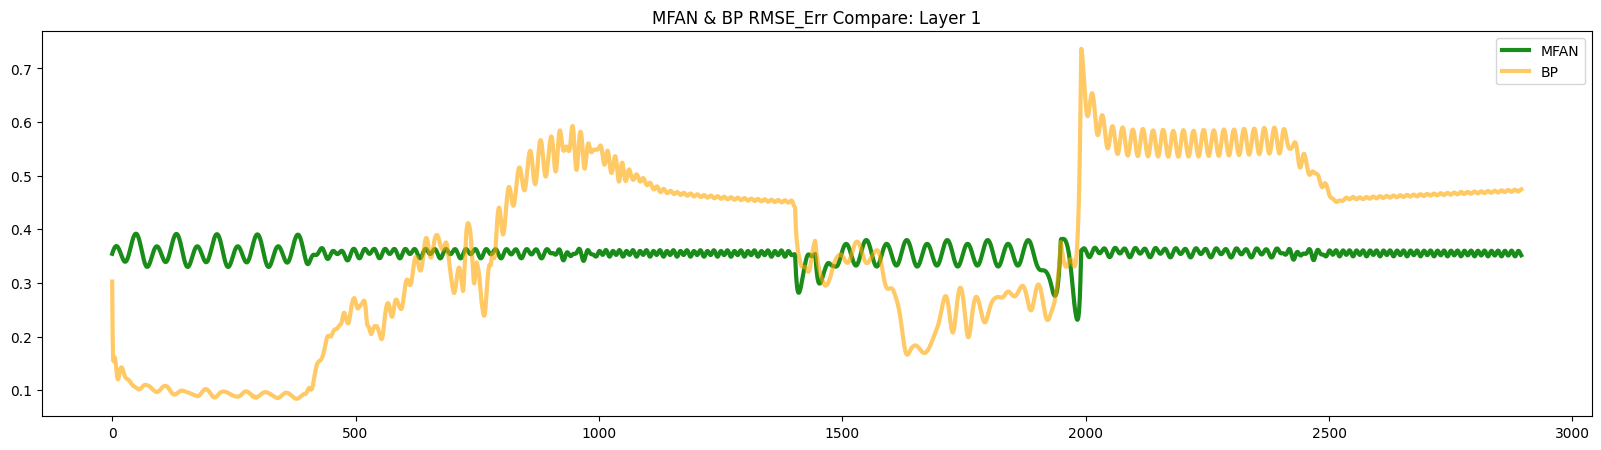

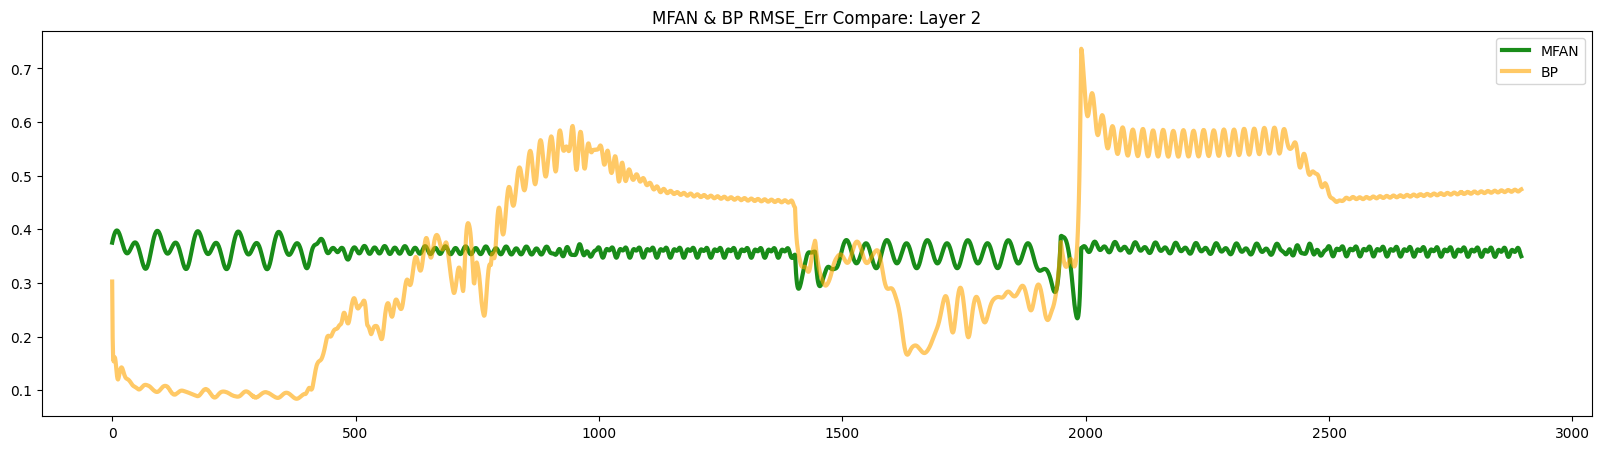

In [14]:
# Plots
print('MFAN')
get_p_lines(collect_x, collect_y_eval_pred, do_tasks)
print('BP')
get_BP_p_lines(collect_BP_x, BP_collect_y_eval_pred, do_tasks)
print('Lowest Error')
get_p(BP_eval_err_collector, MFAN_eval_err_collector, MFAN_use_L)
print('MFAN Layers Error')
get_p_l(BP_eval_err_collector, MFAN_eval_per_layer_err_collector, MFAN_use_L)

## trig tasks

In [15]:
# Define tasks
c = 0
f1 = lambda x: np.sin(0.4*x) + c
f2 = lambda x: -np.cos(0.8*x+0.5*np.pi) + c
f3 = lambda x: np.sin(np.cos(0.7*(x+2)+0.75*np.pi)+1) + c
f4 = lambda x: 2*np.sin(0.4*(x+0.8)) + c
f5 = lambda x: 0.8*np.sin(0.8*x) + c
f6 = lambda x: 0.5*np.sin(1.2*x) + c
do_tasks=[f1,f2,f3,f4,f5,f6]
# Data and Plot
x_data_tr, y_data_tr, y_data_tr_neg = create_time_series_data(do_tasks=[f1,f2,f3,f4,f5,f6], do_plot=False, see_dp=False, see_neg=False, see_tasks=False)
x_stream, y_stream, y_stream_neg = torch.FloatTensor(np.array(x_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr_neg)).to(device)

# Train Model
BP_eval_err_collector, MFAN_eval_err_collector, MFAN_eval_per_layer_err_collector, MFAN_use_L, collect_y_eval_pred, collect_x, BP_collect_y_eval_pred, collect_BP_x = get_results(
    tr_period=5,
    eval_period=1,
    MFAN_lr=[1e-5,1e-5,1e-4], BP_lr=1e-1,
    MFAN_dim=[64,32,16],
    BP_dim=[64,32,16])

show out_data_sizes: 2901 * 100 :[ tensor(0.3777, dtype=torch.float64) ... tensor(19.0762, dtype=torch.float64) ] used all data? tensor(True)


<ipython-input-6-62c2aa8404ca>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt((((y_pred_tr-y_tr_eval)/y_range)**2).mean()).item()) # error measure


num_prints 2896
MFAN took 31.920462369918823 seconds


<ipython-input-3-976d2c0a6bb3>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt((((y_pred_tr-y_tr)/y_range)**2).mean()).item() # error measure


num_prints 2896
BP took 8.405725002288818 seconds


MFAN


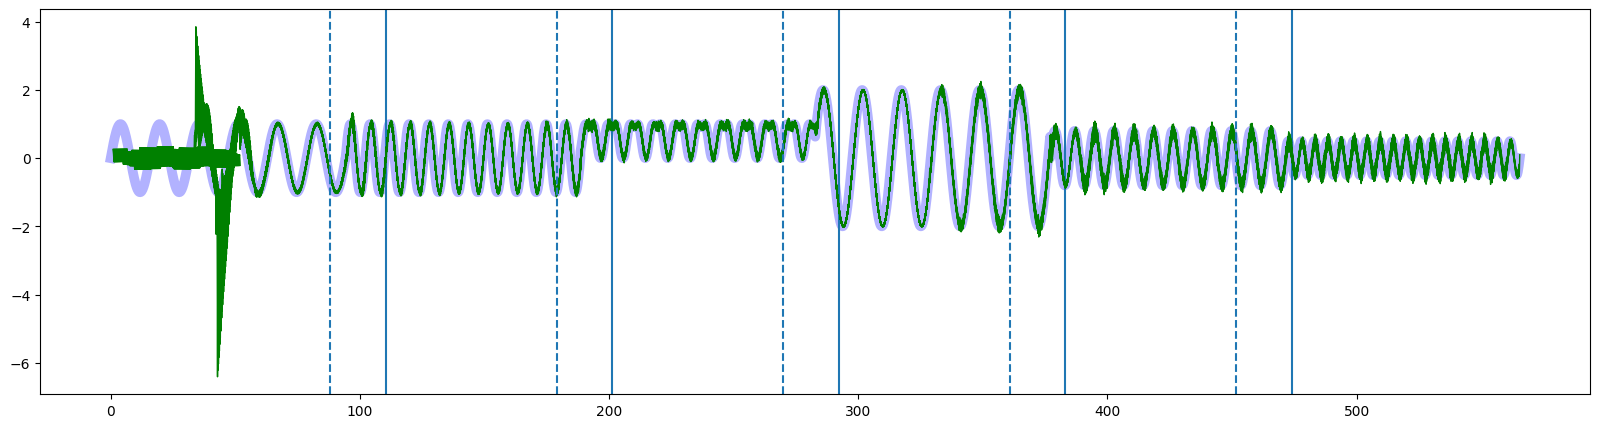

BP


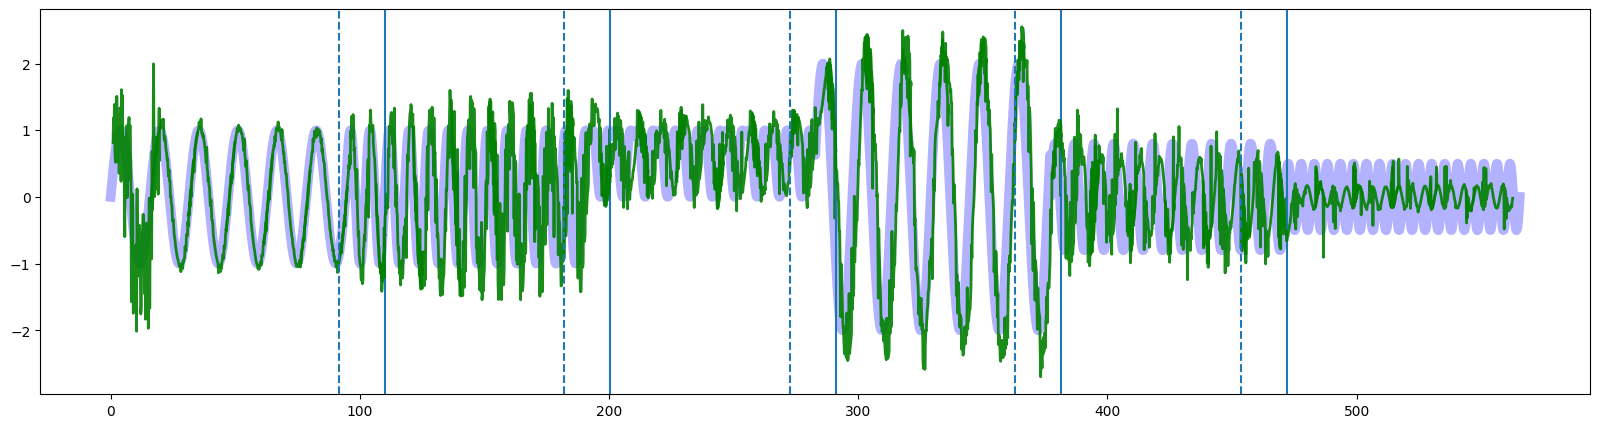

Lowest Error


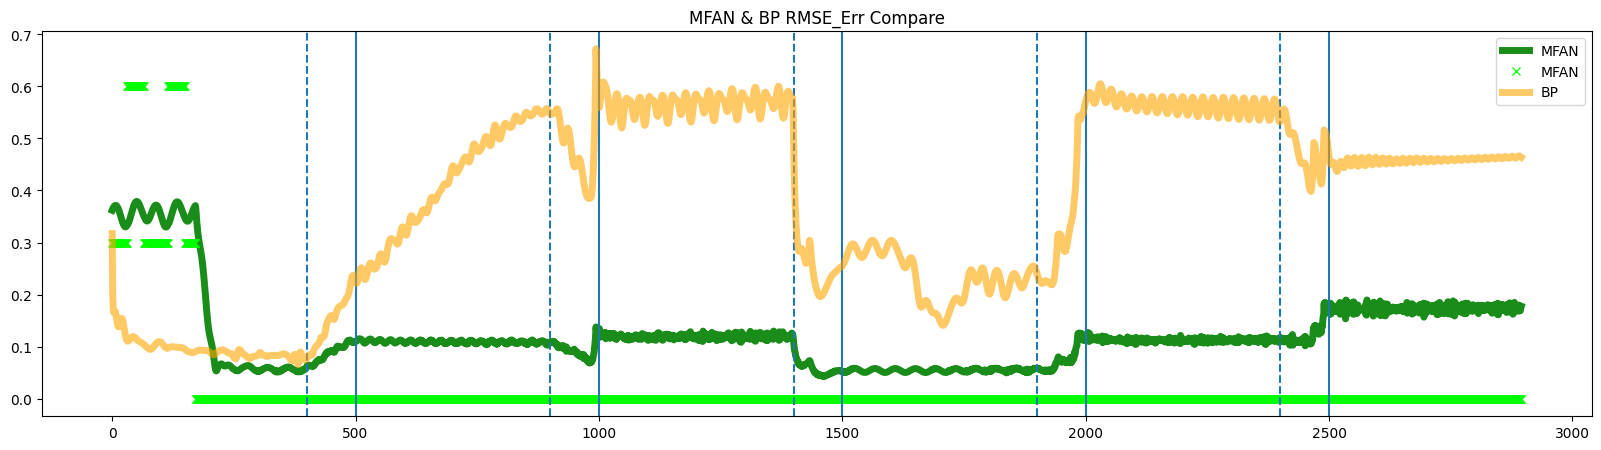

MFAN Layers Error


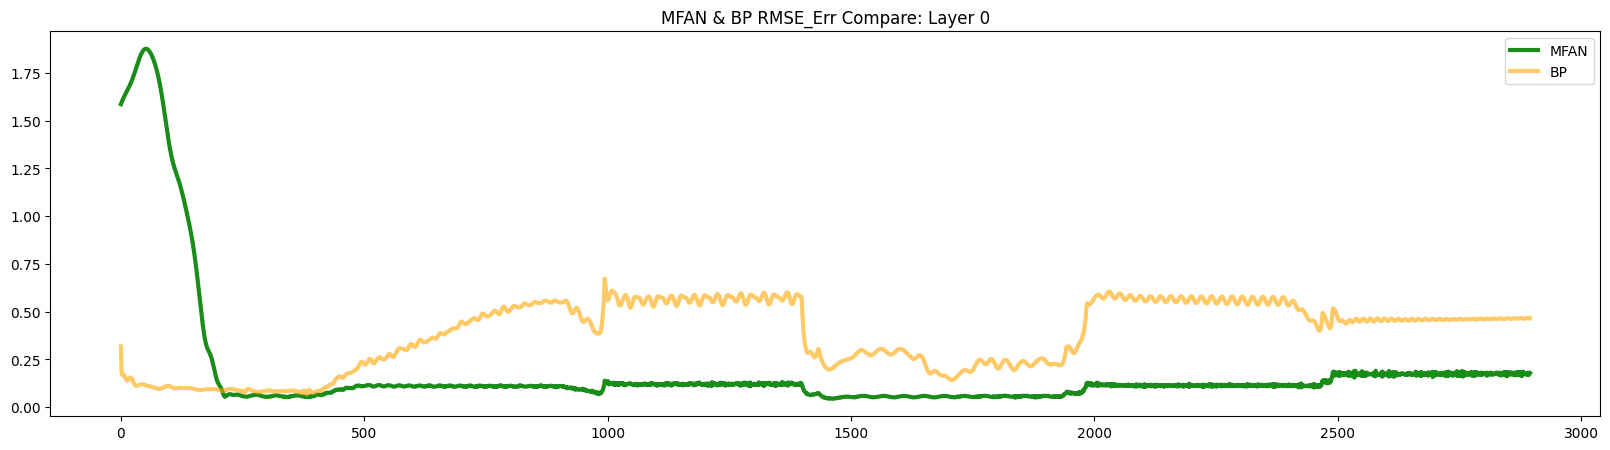

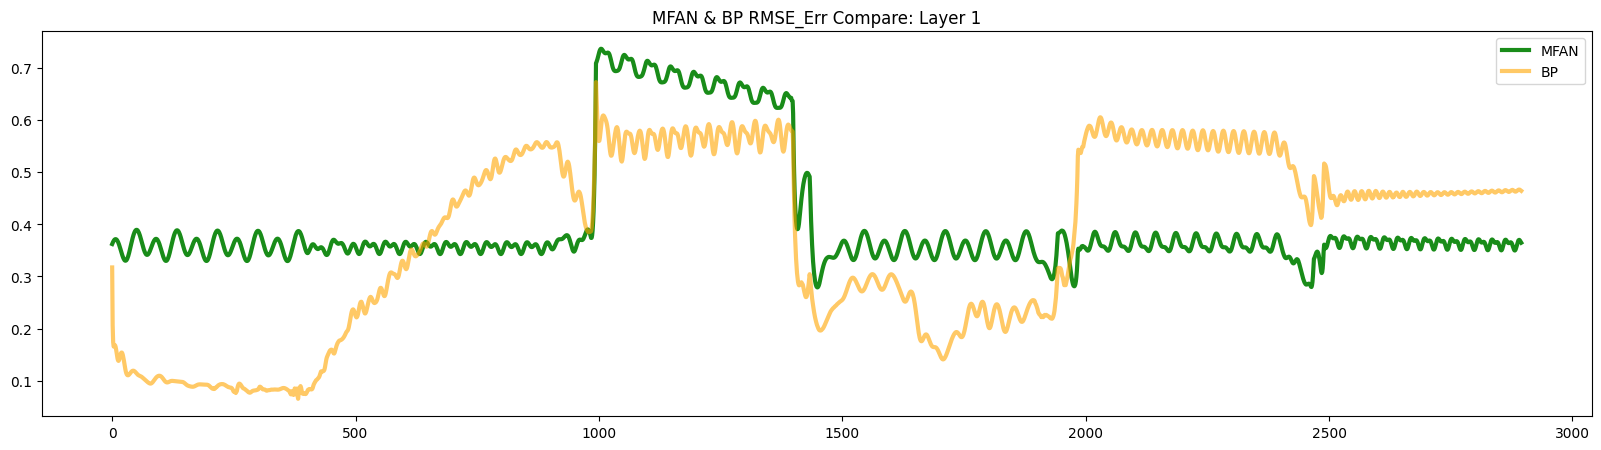

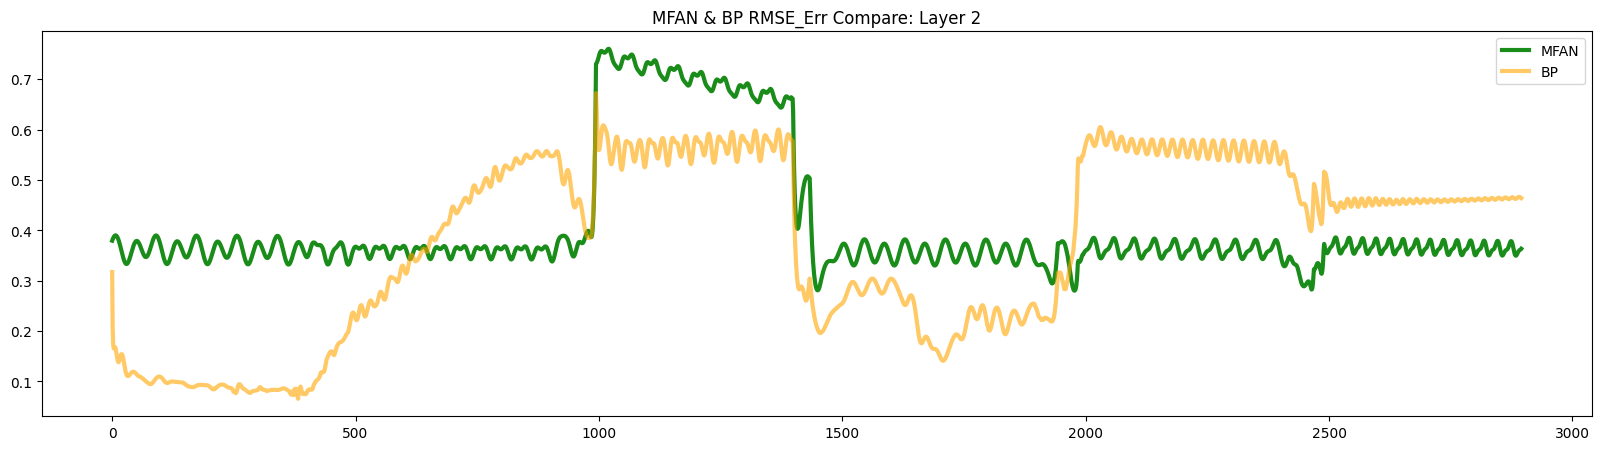

In [17]:
# Plots
print('MFAN')
get_p_lines(collect_x, collect_y_eval_pred, do_tasks)
print('BP')
get_BP_p_lines(collect_BP_x, BP_collect_y_eval_pred, do_tasks)
print('Lowest Error')
get_p(BP_eval_err_collector, MFAN_eval_err_collector, MFAN_use_L)
print('MFAN Layers Error')
get_p_l(BP_eval_err_collector, MFAN_eval_per_layer_err_collector, MFAN_use_L)

## lin trig tasks

In [18]:
# Define tasks
c = 0
f1 = lambda x: np.sin(0.4*x) + c
f2 = lambda x: -np.cos(0.8*x+0.5*np.pi) + c
f3 = lambda x: np.sin(np.cos(0.7*(x+2)+0.75*np.pi)+1) + c
f4 = lambda x: -.008*x+3
f5 = lambda x: 0.8*np.sin(0.8*x) + c
f6 = lambda x: 0.5*np.sin(1.2*x) + c
do_tasks=[f1,f2,f3,f4,f5,f6]
# Data and Plot
x_data_tr, y_data_tr, y_data_tr_neg = create_time_series_data(do_tasks=[f1,f2,f3,f4,f5,f6], do_plot=False, see_dp=False, see_neg=False, see_tasks=False)
x_stream, y_stream, y_stream_neg = torch.FloatTensor(np.array(x_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr)).to(device), torch.FloatTensor(np.array(y_data_tr_neg)).to(device)

# Train Model
BP_eval_err_collector, MFAN_eval_err_collector, MFAN_eval_per_layer_err_collector, MFAN_use_L, collect_y_eval_pred, collect_x, BP_collect_y_eval_pred, collect_BP_x = get_results(
    tr_period=5,
    eval_period=1,
    MFAN_lr=[1e-5,1e-5,1e-4], BP_lr=1e-1,
    MFAN_dim=[64,32,16],
    BP_dim=[64,32,16])

show out_data_sizes: 2901 * 100 :[ tensor(0.3777, dtype=torch.float64) ... tensor(19.0762, dtype=torch.float64) ] used all data? tensor(True)


<ipython-input-6-62c2aa8404ca>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt((((y_pred_tr-y_tr_eval)/y_range)**2).mean()).item()) # error measure


num_prints 2896
MFAN took 35.09594798088074 seconds


<ipython-input-3-976d2c0a6bb3>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt((((y_pred_tr-y_tr)/y_range)**2).mean()).item() # error measure


num_prints 2896
BP took 7.8069236278533936 seconds


MFAN


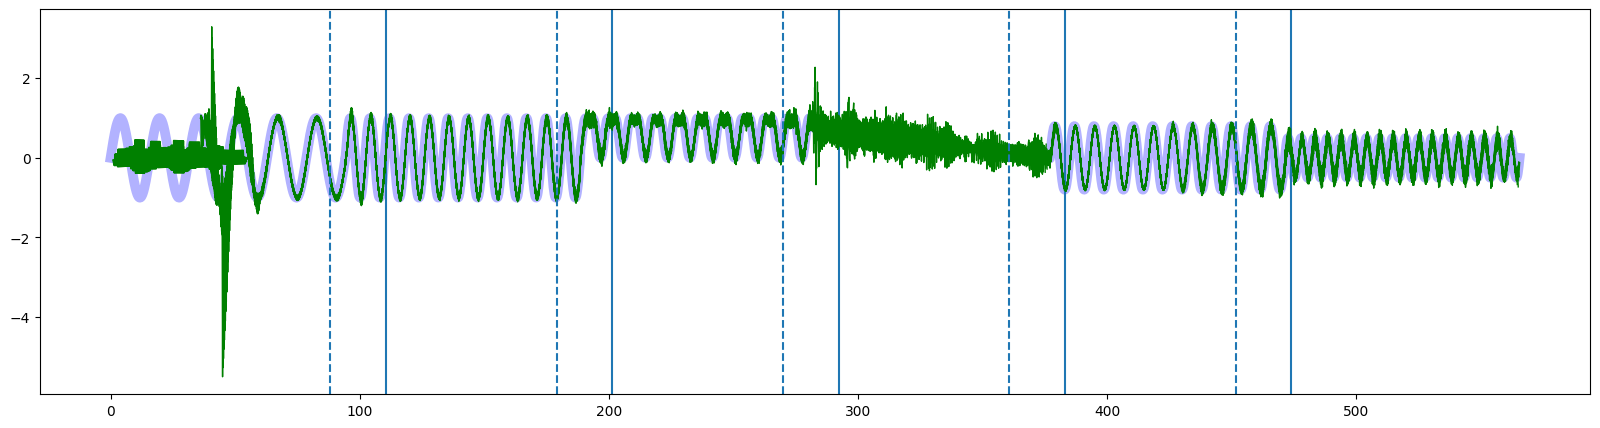

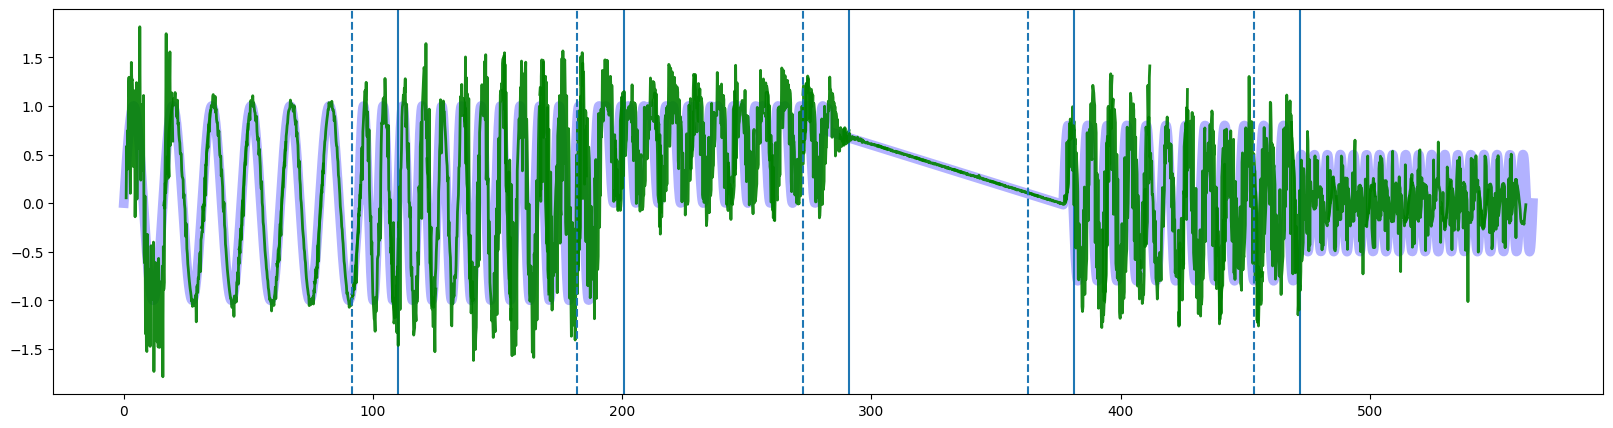

Lowest Error


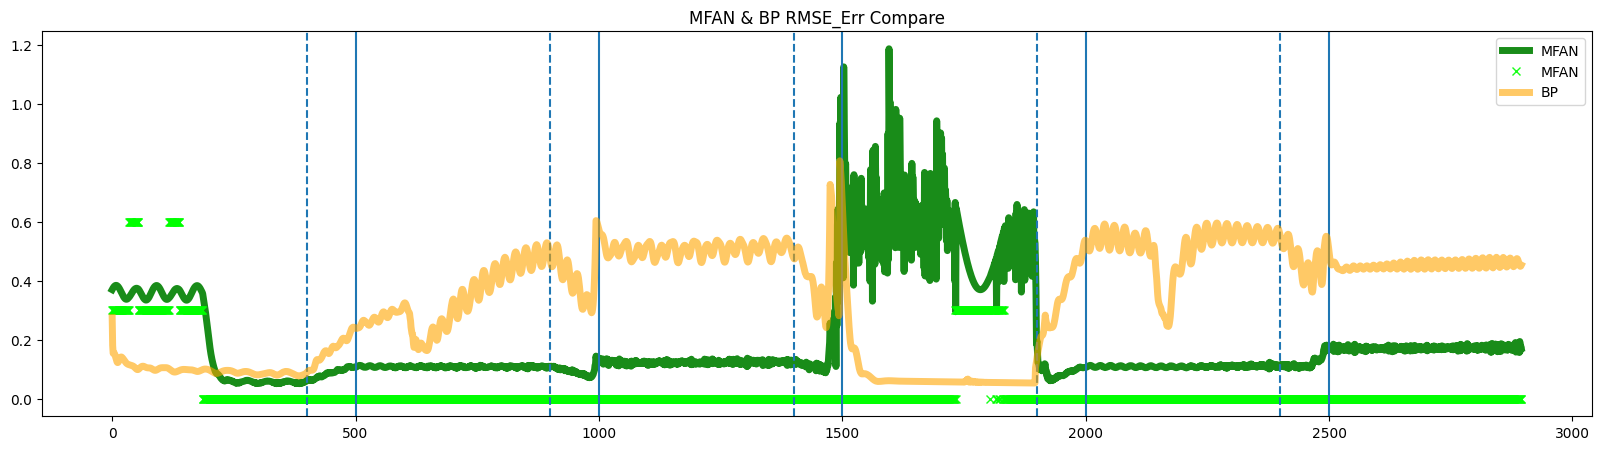

MFAN Layers Error


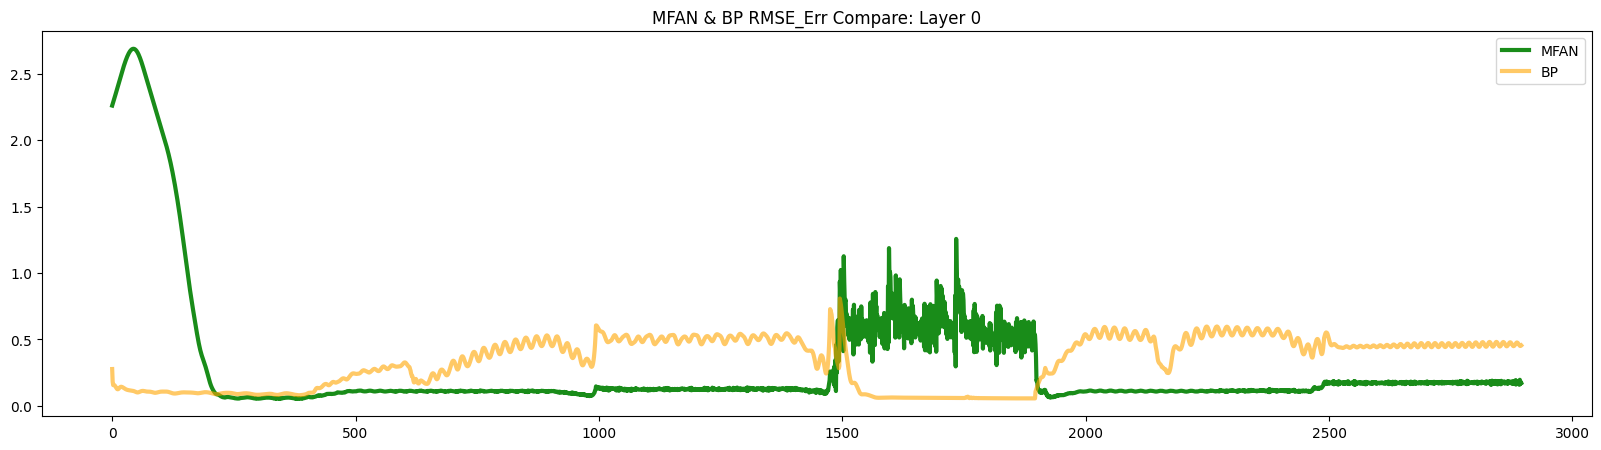

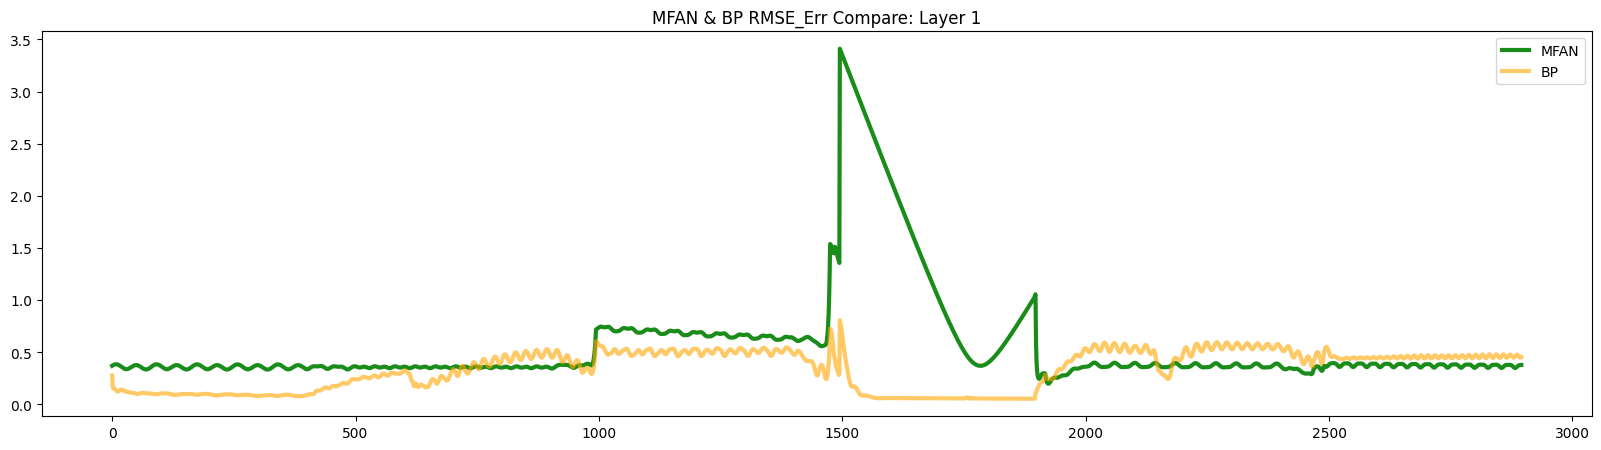

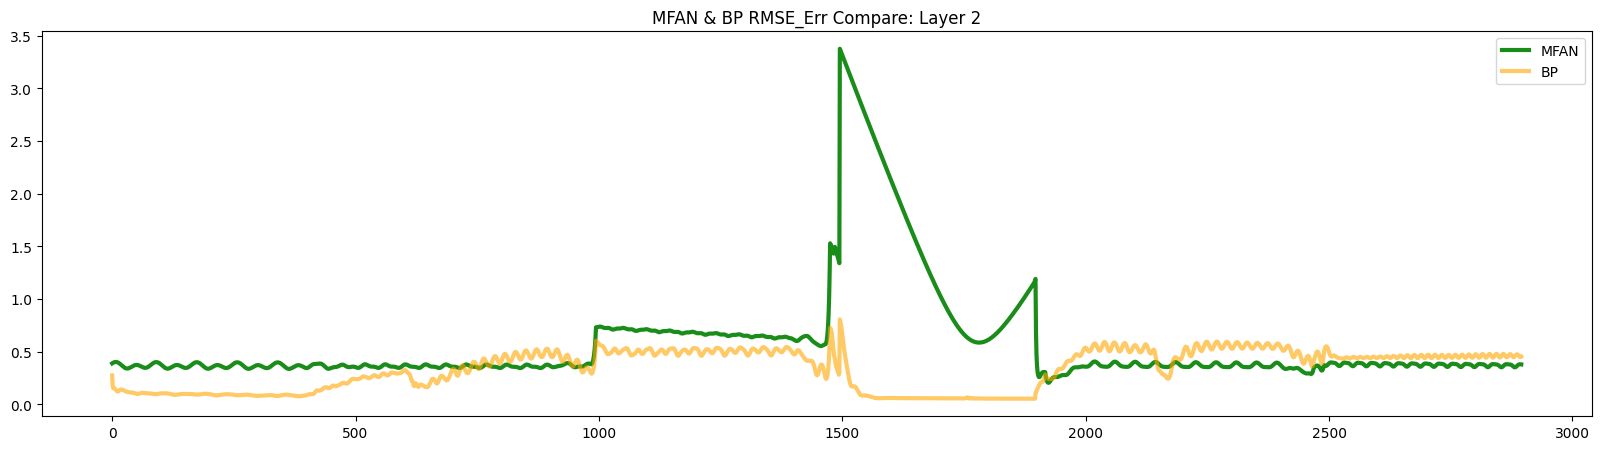

In [19]:
# Plots
print('MFAN')
get_p_lines(collect_x, collect_y_eval_pred, do_tasks)
# print('BP')
get_BP_p_lines(collect_BP_x, BP_collect_y_eval_pred, do_tasks)
print('Lowest Error')
get_p(BP_eval_err_collector, MFAN_eval_err_collector, MFAN_use_L)
print('MFAN Layers Error')
get_p_l(BP_eval_err_collector, MFAN_eval_per_layer_err_collector, MFAN_use_L)